In [1]:
from sys import platform as _platform
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
#if _platform =='linux2':
#    path = '../data/data_sleep/' 
#else:
#    #mets ton path ici et ça devrait marcher :)
#    path = ""
path = "data/"

In [2]:
import seaborn

/home/bat/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
nrows = None
#frequencies=pd.read_csv(path+"data_frequences.csv").drop("Unnamed: 0", axis=1)
frequencies=pd.read_csv(path+"fft_eeg.csv", nrows = nrows)
frequencies_acc =pd.read_csv(path+"fft_acc.csv", nrows = nrows)

stats_acc=pd.read_csv(path+"stats_acc.csv", nrows = nrows)
stats_egg=pd.read_csv(path+"stats_eeg.csv", nrows = nrows)
stats=pd.concat([stats_acc, stats_egg], axis=1)
#ACC_feats =pd.read_csv(path+"ACC_feats.csv").drop("Unnamed: 0", axis=1)
labels_orig=pd.read_csv(path+"challenge_output_data_training_file_sleep_stages_classification.csv", sep=";", nrows = nrows)
#stats = pd.concat([stats.filter(regex="EEG[0-9]*"),stats_ACC], axis=1)
#stats = pd.concat([stats,stats_ACC], axis=1)

frequencies_test=pd.read_csv(path+"fft_eeg_test.csv")
frequencies_acc_test =pd.read_csv(path+"fft_acc_test.csv")
#ACC_feats_test =pd.read_csv(path+"ACC_feats_test.csv").drop("Unnamed: 0", axis=1)
stats_acc_test=pd.read_csv(path+"stats_acc_test.csv")
stats_egg_test=pd.read_csv(path+"stats_eeg_test.csv")
stats_test=pd.concat([stats_acc_test, stats_egg_test], axis=1)

In [4]:
def select_freq_names(low, high, X_columns, prefix = ''):
    return [name for name in X_columns 
            if len(name.split('q'))==2 
            and name.split('freq')[0] == prefix
            and low<=float(name.split('freq')[1]) 
            and high>= float(name.split('freq')[1])]
def group_frequencies(name, low, high, frequencies, prefix = ''):
    frequencies[name]=(1./(high-low) * (frequencies[select_freq_names(low,high,frequencies.columns,prefix)])).sum(axis=1)

In [5]:

#frequencies["delta"]=frequencies[select_freq_names(0,3,frequencies.columns)].sum(axis=1)
#frequencies["delta"]=frequencies[select_freq_names(0,3.99,frequencies.columns)].sum(axis=1)
#frequencies["theta"]=frequencies[select_freq_names(4,7.5,frequencies.columns)].sum(axis=1)
#frequencies["alpha"]=frequencies[select_freq_names(7.5,13.99,frequencies.columns)].sum(axis=1)
#frequencies["beta"]=frequencies[select_freq_names(14,50,frequencies.columns)].sum(axis=1)

def make_new_feats(frequencies):
    group_frequencies("delta1", 0.4, 0.8, frequencies)
    group_frequencies("delta2", 0.81, 1.21, frequencies)
    group_frequencies("delta3", 1.21, 1.99, frequencies)
    group_frequencies("delta4", 2, 3.99, frequencies)
    group_frequencies("theta1", 4, 5, frequencies)
    group_frequencies("theta2", 5, 7.499, frequencies)
    group_frequencies("alpha1", 7.5, 9.5, frequencies)
    group_frequencies("alpha2", 9.5, 10.499, frequencies)
    group_frequencies("alpha3", 10.5, 12, frequencies)
    group_frequencies("alpha4", 12, 13.5, frequencies)
    group_frequencies("beta1", 14, 20, frequencies)
    group_frequencies("beta2", 20, 30, frequencies)
    group_frequencies("beta3", 31, 45, frequencies)
    group_frequencies("beta4", 45, 50, frequencies)



In [6]:
def regroup_acc_freq (frequencies_acc):
    for prefix in ['ACC_X.','ACC_Y.','ACC_Z.']:
        group_frequencies(prefix+"smaller_one",0.01,1, frequencies_acc,prefix)
        group_frequencies(prefix+"one_to_two",1.01,2, frequencies_acc,prefix)
        group_frequencies(prefix+"two_to_three",2.01,3, frequencies_acc,prefix)
        group_frequencies(prefix+"three_to_four",3.01,4, frequencies_acc,prefix)
        group_frequencies(prefix+"more_four",4,10, frequencies_acc,prefix)




In [7]:
def make_new_features(f, stat, f_acc):
    new_feat = ["delta1","delta2","delta3",'delta4', 'theta1', 'theta2', 'alpha1','alpha2','alpha3','alpha4', 'beta1','beta2','beta3','beta4']
    make_new_feats(f)
    
    prefixes = ['ACC_X.','ACC_Y.','ACC_Z.']
    regroup_acc_freq (f_acc)
    frequencies_acc2 = f_acc[[prefix+ x for x in["smaller_one","one_to_two","two_to_three",'more_four']for prefix in prefixes]]
    
    return  pd.concat([f[new_feat], stat, frequencies_acc2], axis=1)

In [8]:
train = make_new_features(frequencies, stats, frequencies_acc)
test = make_new_features(frequencies_test, stats_test, frequencies_acc_test)

In [9]:
labels = labels_orig.drop(train[train["delta1"] > 10000].index)
train=train.drop(train[train["delta1"] > 10000].index)

In [10]:
train.describe()

,delta1,delta2,delta3,delta4,theta1,theta2,alpha1,alpha2,alpha3,alpha4,beta1,beta2,beta3,beta4,ACC_X_quantile_0,ACC_X_quantile_10,ACC_X_quantile_20,ACC_X_quantile_30,ACC_X_quantile_40,ACC_X_quantile_50,ACC_X_quantile_60,ACC_X_quantile_70,ACC_X_quantile_80,ACC_X_quantile_90,ACC_X_quantile_100,mean_ACC_X,var_ACC_X,skew_ACC_X,kurt_ACC_X,ACC_Y_quantile_0,ACC_Y_quantile_10,ACC_Y_quantile_20,ACC_Y_quantile_30,ACC_Y_quantile_40,ACC_Y_quantile_50,ACC_Y_quantile_60,ACC_Y_quantile_70,ACC_Y_quantile_80,ACC_Y_quantile_90,ACC_Y_quantile_100,mean_ACC_Y,var_ACC_Y,skew_ACC_Y,kurt_ACC_Y,ACC_Z_quantile_0,ACC_Z_quantile_10,ACC_Z_quantile_20,ACC_Z_quantile_30,ACC_Z_quantile_40,ACC_Z_quantile_50,ACC_Z_quantile_60,ACC_Z_quantile_70,ACC_Z_quantile_80,ACC_Z_quantile_90,ACC_Z_quantile_100,mean_ACC_Z,var_ACC_Z,skew_ACC_Z,kurt_ACC_Z,EEG_quantile_0,EEG_quantile_10,EEG_quantile_20,EEG_quantile_30,EEG_quantile_40,EEG_quantile_50,EEG_quantile_60,EEG_quantile_70,EEG_quantile_80,EEG_quantile_90,EEG_quantile_100,mean_EEG,var_EEG,skew_EEG,kurt_EEG,EEG_through_0,EEG_through_mean,ACC_X.smaller_one,ACC_Y.smaller_one,ACC_Z.smaller_one,ACC_X.one_to_two,ACC_Y.one_to_two,ACC_Z.one_to_two,ACC_X.two_to_three,ACC_Y.two_to_three,ACC_Z.two_to_three,ACC_X.more_four,ACC_Y.more_four,ACC_Z.more_four
count,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,3.112800e+04,31128.000000,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,3.112800e+04,31128.000000,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,3.112800e+04,31128.000000,3.112800e+04,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000,31128.000000
mean,56.613403,25.249048,12.934573,6.582232,4.263254,3.173376,2.685000,2.378316,2.170850,1.856773,1.121987,0.786170,0.593482,0.511146,-7.423143e+04,-70100.228579,-62274.560420,-45206.892940,-24473.196606,-2680.118137,19442.707510,41191.771991,62109.467397,77356.688846,8.218016e+04,537289.767292,3.330339e+10,-0.024520,1.037846,-7.709339e+04,-73117.934886,-64881.307901,-46638.038636,-25246.630801,-2388.639676,20462.128903,43432.320419,64535.899020,79785.213543,8.457110e+04,585567.728568,3.488700e+10,-0.039890,1.229492,-7.832675e+04,-72463.289367,-65682.832822,-48826.994779,-26349.672310,-2997.177483,20555.310290,44427.157704,65843.010144,81056.082081,8.571842e+04,467418.657534,3.552050e+10,0.056374,1.169261,-65.505027,-24.063934,-14.710690,-8.834041,-4.245952,-0.122066,4.017014,8.652046,14.597249,24.079254,65.825801,-0.307710,797.309588,0.042310,1.887117,266.305834,266.226902,55259.539742,59062.267077,68200.990046,45071.702893,46031.113001,52877.909848,58956.644160,60439.322980,57636.250844,6722.977664,6420.037437,7003.176828
std,66.011284,21.003636,9.201005,3.725917,2.302072,1.616906,1.393210,1.347707,1.059642,0.976722,0.721856,0.738372,0.757256,0.772962,2.306999e+05,222170.019983,199718.355252,147324.530336,82395.494080,25886.803158,66644.654971,133777.995479,199300.938450,245556.823334,2.565174e+05,576191.926545,1.071636e+11,0.977889,8.421208,2.359178e+05,227945.872186,204623.232933,149742.182054,85528.309934,29113.269698,69365.836318,139389.669428,204306.058871,249915.459529,2.590731e+05,657679.823820,1.104890e+11,1.113460,9.874830,2.358901e+05,223627.

In [11]:
test.describe()

,delta1,delta2,delta3,delta4,theta1,theta2,alpha1,alpha2,alpha3,alpha4,beta1,beta2,beta3,beta4,ACC_X_quantile_0,ACC_X_quantile_10,ACC_X_quantile_20,ACC_X_quantile_30,ACC_X_quantile_40,ACC_X_quantile_50,ACC_X_quantile_60,ACC_X_quantile_70,ACC_X_quantile_80,ACC_X_quantile_90,ACC_X_quantile_100,mean_ACC_X,var_ACC_X,skew_ACC_X,kurt_ACC_X,ACC_Y_quantile_0,ACC_Y_quantile_10,ACC_Y_quantile_20,ACC_Y_quantile_30,ACC_Y_quantile_40,ACC_Y_quantile_50,ACC_Y_quantile_60,ACC_Y_quantile_70,ACC_Y_quantile_80,ACC_Y_quantile_90,ACC_Y_quantile_100,mean_ACC_Y,var_ACC_Y,skew_ACC_Y,kurt_ACC_Y,ACC_Z_quantile_0,ACC_Z_quantile_10,ACC_Z_quantile_20,ACC_Z_quantile_30,ACC_Z_quantile_40,ACC_Z_quantile_50,ACC_Z_quantile_60,ACC_Z_quantile_70,ACC_Z_quantile_80,ACC_Z_quantile_90,ACC_Z_quantile_100,mean_ACC_Z,var_ACC_Z,skew_ACC_Z,kurt_ACC_Z,EEG_quantile_0,EEG_quantile_10,EEG_quantile_20,EEG_quantile_30,EEG_quantile_40,EEG_quantile_50,EEG_quantile_60,EEG_quantile_70,EEG_quantile_80,EEG_quantile_90,EEG_quantile_100,mean_EEG,var_EEG,skew_EEG,kurt_EEG,EEG_through_0,EEG_through_mean,ACC_X.smaller_one,ACC_Y.smaller_one,ACC_Z.smaller_one,ACC_X.one_to_two,ACC_Y.one_to_two,ACC_Z.one_to_two,ACC_X.two_to_three,ACC_Y.two_to_three,ACC_Z.two_to_three,ACC_X.more_four,ACC_Y.more_four,ACC_Z.more_four
count,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,3.045800e+04,30458.000000,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,3.045800e+04,30458.000000,3.045800e+04,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000,30458.000000
mean,51.873624,26.285790,13.739534,6.794295,4.340244,3.167898,2.499432,2.196317,2.072822,1.755938,1.083713,0.781358,0.575024,0.539771,-1.145230e+05,-111048.677018,-100698.254404,-76367.358002,-42781.896587,-7082.730902,29306.899186,65905.320313,101122.176745,129758.757400,1.377721e+05,678133.310874,5.457041e+10,0.007856,0.503843,-1.222342e+05,-116595.967467,-102236.230455,-73437.622626,-39340.833020,-3954.962660,31869.319386,67578.047117,100848.793363,127765.414439,136174.835741,674523.009937,5.458737e+10,0.035224,0.809234,-116153.658731,-112442.934588,-102521.749192,-78800.863642,-44705.219286,-7962.073985,30023.007365,67938.846590,104098.899370,131597.606695,1.419687e+05,581850.570548,5.574086e+10,0.041560,0.600053,-63.043131,-22.319276,-13.707544,-8.295338,-4.013803,-0.125879,3.784794,8.128503,13.610392,22.362700,64.487093,-0.329917,618.463526,0.059365,1.787492,295.440935,295.697649,88299.482826,88500.440793,95394.274575,81514.311799,73358.578653,89083.058384,92921.692146,89994.768631,98861.250739,10914.984852,10595.137854,11014.606995
std,54.592059,21.173179,9.861936,3.736462,2.131689,1.404761,1.241717,1.140811,0.966013,0.818734,0.544895,0.509729,0.498638,1.010762,2.724327e+05,267295.351552,243833.494474,188134.274879,109468.373677,36720.401592,77956.123775,162953.684259,246088.905634,312813.442477,3.274585e+05,576678.553613,1.328382e+11,0.759419,6.397556,2.873461e+05,277707.940705,246498.443169,180289.221161,101464.489926,35038.250351,82607.392994,164866.027756,243061.047349,305367.062589,320491.500262,646824.532816,1.317086e+11,0.979405,9.189251,27

In [12]:
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
y_train = labels['TARGET']
X = train.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z","ID"], axis=1)
X_t = test.drop(["skew_ACC_X","skew_ACC_Y", "skew_ACC_Z","ID"], axis=1)
#X = train.drop(["mean_EEG"], axis=1)
#X_t = test.drop(["mean_EEG"], axis=1)
valid_bool= False
if(valid_bool):
    X, X_t, y_train, y_test = train_test_split(
        X, labels["TARGET"], test_size=0.2)

scaler = StandardScaler().partial_fit(X)
scaler = StandardScaler().partial_fit(X_t)
X_train = scaler.transform(X)
X_test = scaler.transform(X_t)
X_columns = X.columns

In [13]:
%%time
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import cohen_kappa_score,accuracy_score
et = ExtraTreesClassifier(random_state = 42,n_estimators=500, max_depth= 29, n_jobs = 3)#, class_weight = 'balanced')
et.fit(X_train, y_train)
predicted_label = et.predict(X_test)

if(valid_bool):
    print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
    print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))
print("Extra Random Trees - kappa Score on train data : ", cohen_kappa_score(y_train, et.predict(X_train)))

('Extra Random Trees - kappa Score on train data : ', 0.99964833296744127)
CPU times: user 2min 37s, sys: 2.34 s, total: 2min 40s
Wall time: 1min 2s


In [14]:
#from sklearn.metrics import accuracy_score
#print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
#print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))

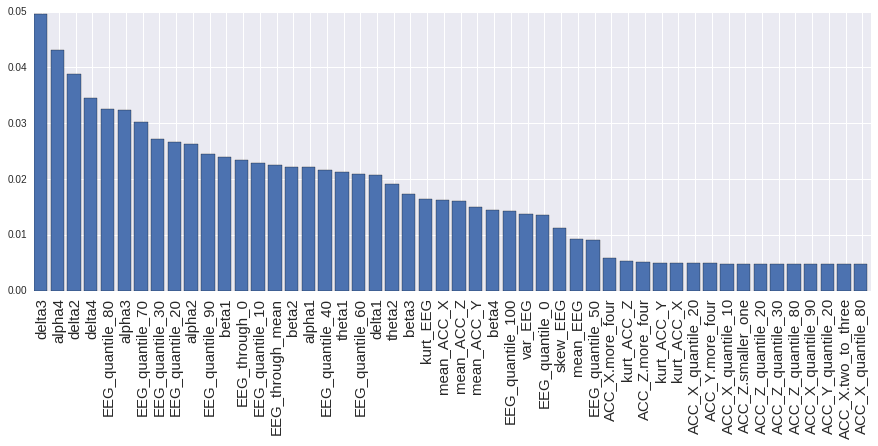

In [15]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(et.feature_importances_)[::-1][:50]

importances = et.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [16]:
%%time
from sklearn.cross_validation import cross_val_score
scores = cross_val_score(et, X_train, y_train, cv=5, scoring="accuracy",n_jobs=3)
print("accuracy: {:.4f} +/-{:.4f}".format(
    np.mean(scores), np.std(scores)))

accuracy: 0.8504 +/-0.0055
CPU times: user 340 ms, sys: 278 ms, total: 617 ms
Wall time: 2min 40s


In [17]:
%%time
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier(
    n_estimators=500, 
    random_state=42,
    max_depth=18,
#    max_features=0.6,
#    subsample=0.9,
    learning_rate=0.01,
    verbose=0.5
)
gbc=GradientBoostingClassifier(
    n_estimators=200, 
    random_state=42,
    max_depth=15,
    max_features=0.6,
    subsample=0.9,
    learning_rate=0.05,
    verbose=0.5
)
from sklearn.cross_validation import cross_val_score
#scores = cross_val_score(gbc, X_train, y_train, cv=5, scoring="accuracy",n_jobs=3)
#print("accuracy: {:.4f} +/-{:.4f}".format(
#    np.mean(scores), np.std(scores)))



CPU times: user 138 µs, sys: 6 µs, total: 144 µs
Wall time: 145 µs


In [18]:
gbc.fit(X_train,y_train)
predicted_label = gbc.predict(X_test)
if(valid_bool):
    print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
    print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))

      Iter       Train Loss      OOB Improve   Remaining Time 
         1       36830.4367         339.7469          145.21m
         2       33406.4796         289.5445          172.55m
         3       30436.1348         246.0723          188.97m
         4       27848.3988         216.4858          199.79m
         5       25560.7389         186.9621          199.03m
         6       23522.4344         169.2621          205.52m
         7       21685.7410         147.2772          207.14m
         8       20019.8096         134.8468          209.63m
         9       18496.9980         120.9056          215.86m
        10       17127.5494         110.2593          222.81m
        11       15880.5523         100.4230          222.48m
        12       14723.4947          89.7896          220.67m
        13       13697.8484          83.0164          221.07m
        14       12710.0502          75.9871          220.07m
        15       11827.7100          68.7321          221.70m
       

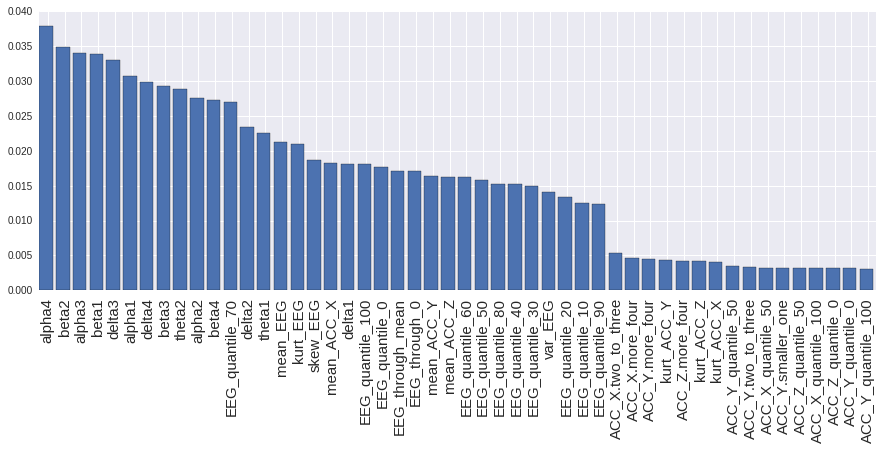

In [19]:
plt.figure(figsize=(15, 5))

ordering = np.argsort(gbc.feature_importances_)[::-1][:50]

importances = gbc.feature_importances_[ordering]
feature_names = X_columns[ordering]

x = np.arange(len(feature_names))
plt.bar(x, importances)
plt.xticks(x + 0.5, feature_names, rotation=90, fontsize=15);

In [112]:
prob_et = et.predict_proba(X_test)
prob_gbc = gbc.predict_proba(X_test)

In [113]:
print prob_et
print prob_gbc

[[  4.00865801e-03   4.08658009e-03   1.24221068e-01   8.65800866e-06
    8.67675036e-01]
 [  8.48877154e-03   9.34177822e-03   4.68324870e-01   5.06523424e-01
    7.32115583e-03]
 [  6.63548820e-03   1.25660140e-02   4.84019361e-01   4.59624726e-01
    3.71544104e-02]
 ..., 
 [  2.10970826e-03   3.17460317e-05   4.44721116e-02   9.53298511e-01
    8.79234143e-05]
 [  1.05324100e-02   8.78264804e-02   1.36848922e-01   1.42857143e-04
    7.64649331e-01]
 [  2.76841377e-02   1.44055205e-02   3.80555167e-01   2.47003908e-03
    5.74885135e-01]]
[[  3.32992467e-05   3.18729748e-05   2.99067663e-04   2.87147785e-05
    9.99607045e-01]
 [  3.58590627e-04   2.83743269e-04   1.50477242e-02   9.83894382e-01
    4.15559523e-04]
 [  5.56344649e-04   4.35360333e-04   8.93199521e-01   1.04986517e-01
    8.22256971e-04]
 ..., 
 [  5.90507591e-06   5.01069444e-06   2.89796216e-05   9.99953896e-01
    6.20813888e-06]
 [  8.04047879e-05   1.14386467e-04   4.97361648e-04   5.73290937e-05
    9.99250518e

In [114]:
weighted_prob = (4*prob_gbc + prob_et)
predicted_label = np.apply_along_axis(lambda x: np.argmax(x),1,weighted_prob)

In [115]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(5)
    plt.xticks(tick_marks, [0,1,2,3,4], rotation=45)
    plt.yticks(tick_marks, [0,1,2,3,4])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


[[  7.14285714e-01   3.86100386e-03   2.00772201e-01   2.70270270e-02
    5.40540541e-02]
 [  6.09756098e-02   3.04878049e-01   3.90243902e-01   2.43902439e-02
    2.19512195e-01]
 [  1.29996750e-03   3.24991875e-04   8.98602535e-01   6.36984075e-02
    3.60740981e-02]
 [  5.12820513e-04   0.00000000e+00   1.09743590e-01   8.88717949e-01
    1.02564103e-03]
 [  1.16550117e-03   0.00000000e+00   2.83216783e-01   2.33100233e-03
    7.13286713e-01]]


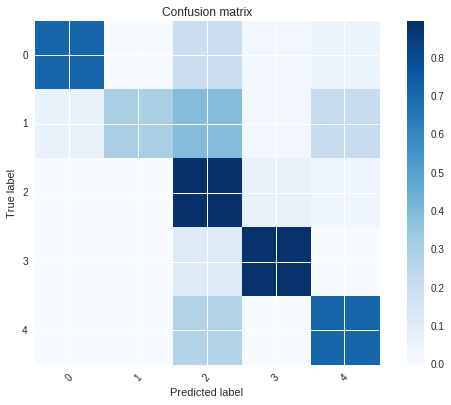

In [116]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, et.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
plt.figure()
plot_confusion_matrix(cm)

[[  7.29729730e-01   0.00000000e+00   1.81467181e-01   3.47490347e-02
    5.40540541e-02]
 [  9.75609756e-02   3.41463415e-01   3.65853659e-01   1.21951220e-02
    1.82926829e-01]
 [  1.62495938e-03   0.00000000e+00   9.05427364e-01   5.45986350e-02
    3.83490413e-02]
 [  5.12820513e-04   0.00000000e+00   1.00512821e-01   8.97948718e-01
    1.02564103e-03]
 [  3.49650350e-03   0.00000000e+00   1.92307692e-01   6.99300699e-03
    7.97202797e-01]]


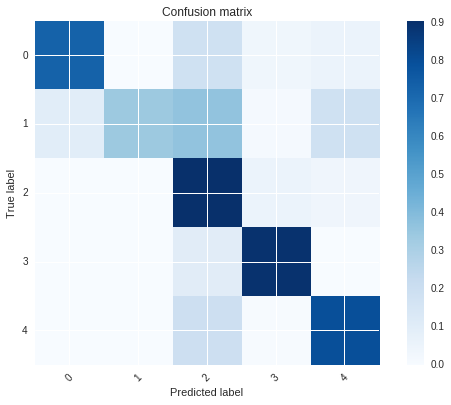

In [117]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, gbc.predict(X_test))
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
plt.figure()
plot_confusion_matrix(cm)

[[  7.29729730e-01   0.00000000e+00   1.81467181e-01   3.47490347e-02
    5.40540541e-02]
 [  8.53658537e-02   3.53658537e-01   3.53658537e-01   1.21951220e-02
    1.95121951e-01]
 [  1.62495938e-03   0.00000000e+00   9.05427364e-01   5.49236269e-02
    3.80240494e-02]
 [  5.12820513e-04   0.00000000e+00   1.00512821e-01   8.98461538e-01
    5.12820513e-04]
 [  3.49650350e-03   0.00000000e+00   1.93473193e-01   6.99300699e-03
    7.96037296e-01]]


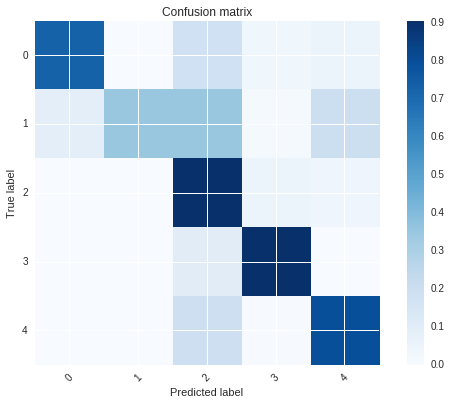

In [118]:
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(y_test, predicted_label)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print cm
plt.figure()
plot_confusion_matrix(cm)

In [119]:
weighted_prob = (3*prob_gbc + prob_et)
predicted_label = np.apply_along_axis(lambda x: np.argmax(x),1,weighted_prob)

In [120]:
print("Extra Random Trees - accuracy Score on test_data : ", accuracy_score(y_test, predicted_label))
print("Extra Random Trees - kappa Score on test_data : ", cohen_kappa_score(y_test, predicted_label))

('Extra Random Trees - accuracy Score on test_data : ', 0.87391583681336327)
('Extra Random Trees - kappa Score on test_data : ', 0.7988121485862727)


In [20]:
def make_submission(predicted_label, name = 'submit.csv'):
    ids = pd.read_csv('../data/data_sleep/input_test.csv', usecols= ['ID'])
    #ids = pd.DataFrame()
    #ids ["ID"]= test["ID"]
    ids["TARGET"] = pd.Series(predicted_label).astype(float)
    #ids['TARGET']= ids['TARGET'].astype(int)
    ids.to_csv(name,index=False)

In [21]:
make_submission(predicted_label)

In [ ]:
predicted_label_train = et.predict(X_train)

In [22]:
import collections
print collections.Counter(predicted_label), collections.Counter(y_train)

Counter({2.0: 16541, 3.0: 10011, 4.0: 3477, 0.0: 382, 1.0: 47}) Counter({2.0: 15334, 3.0: 9640, 4.0: 4385, 0.0: 1341, 1.0: 428})


In [23]:
import collections
print collections.Counter(predicted_label), collections.Counter(y_train)

Counter({2.0: 16541, 3.0: 10011, 4.0: 3477, 0.0: 382, 1.0: 47}) Counter({2.0: 15334, 3.0: 9640, 4.0: 4385, 0.0: 1341, 1.0: 428})


In [ ]:
X_train.shape, X_test.shape

In [ ]:
31129 - 6130